In [1]:
import sys
sys.path.insert(1, './custom_modules')

In [2]:
#### create config
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 256  # TODO: the generated image resolution
    image_shape = (256,256,160)
    channels = 1
    train_batch_size = 4 
    eval_batch_size = 4  
    num_epochs = 350
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    evaluate_epochs = 40 # anpassen auf Anzahl epochs
    evaluate_num_batches = 2 # one batch needs ~130s 
    deactivate3Devaluation = True
    evaluate_3D_epochs = 1000  # one 3D evaluation has 77 slices and needs 166min
    save_model_epochs = 300
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "lesion-filling-256-repaint"  # the model name locally and on the HF Hub
    dataset_train_path = "./datasets/filling/dataset_train/imgs"
    segm_train_path = "./datasets/filling/dataset_train/segm"
    masks_train_path = "./datasets/filling/dataset_train/masks"
    dataset_eval_path = "./datasets/filling/dataset_eval/imgs"
    segm_eval_path = "./datasets/filling/dataset_eval/segm"
    masks_eval_path = "./datasets/filling/dataset_eval/masks"  
    train_only_connected_masks=False  # No Training with lesion masks
    eval_only_connected_masks=False 
    num_inference_steps=50 
    log_csv = False
    mode = "train" # train / eval
    debug = True
    jump_length=8
    jump_n_sample=10 
    #uniform_dataset_path = "./uniform_dataset"

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    #hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    #hub_private_repo = False
    #overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0
config = TrainingConfig()

In [3]:
if config.debug:
    config.num_inference_steps=1
    config.train_batch_size = 1
    config.eval_batch_size = 1 
    config.train_only_connected_masks=False
    config.eval_only_connected_masks=False
    config.evaluate_num_batches=1
    dataset_train_path = "./dataset_eval/imgs"
    segm_train_path = "./dataset_eval/segm"
    masks_train_path = "./dataset_eval/masks"  
    config.jump_length=1
    config.jump_n_sample=1

In [4]:
#setup huggingface accelerate
import torch
import numpy as np
import accelerate
accelerate.commands.config.default.write_basic_config(config.mixed_precision)

Configuration already exists at /home/jovyan/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

In [11]:
from DatasetMRI2D import DatasetMRI2D
from DatasetMRI3D import DatasetMRI3D
from pathlib import Path

#create dataset
datasetTrain = DatasetMRI2D(root_dir_img=Path(config.dataset_train_path), root_dir_segm=Path(config.segm_train_path), only_connected_masks=config.train_only_connected_masks)
datasetEvaluation = DatasetMRI2D(root_dir_img=Path(config.dataset_eval_path), root_dir_masks=Path(config.masks_eval_path), only_connected_masks=config.eval_only_connected_masks)
dataset3DEvaluation = DatasetMRI3D(root_dir_img=Path(config.dataset_eval_path), root_dir_masks=Path(config.masks_eval_path), only_connected_masks=config.eval_only_connected_masks)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
#create model
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=config.channels,  # the number of input channels, 3 for RGB images
    out_channels=config.channels,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

config.model = "UNet2DModel"

In [6]:
#setup noise scheduler
import torch
from PIL import Image
from diffusers import DDIMScheduler

noise_scheduler = DDIMScheduler(num_train_timesteps=1000)

config.noise_scheduler = "DDIMScheduler(num_train_timesteps=1000)"

In [7]:
# setup lr scheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
import math

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(math.ceil(len(datasetTrain)/config.train_batch_size) * config.num_epochs), # num_iterations per epoch * num_epochs
)
config.lr_scheduler = "cosine_schedule_with_warmup"

NameError: name 'datasetTrain' is not defined

In [ ]:
from TrainingUnconditional import TrainingUnconditional
from RePaintPipeline import RePaintPipeline
from Evaluation2DFilling import Evaluation2DFilling
from Evaluation3DFilling import Evaluation3DFilling 
import PipelineFactories

config.conditional_data = "None"

In [ ]:
if config.mode == "train":
    args = {
        "config": config, 
        "model": model, 
        "noise_scheduler": noise_scheduler, 
        "optimizer": optimizer, 
        "lr_scheduler": lr_scheduler, 
        "datasetTrain": datasetTrain, 
        "datasetEvaluation": datasetEvaluation, 
        "dataset3DEvaluation": dataset3DEvaluation, 
        "evaluation2D": Evaluation2DFilling,
        "evaluation3D": Evaluation3DFilling, 
        "pipelineFactory": PipelineFactories.get_repaint_pipeline,
        "deactivate3Devaluation": config.deactivate3Devaluation,
        "evaluation_pipeline_parameters": {
                    "jump_length": config.jump_length,
                    "jump_n_sample": config.jump_n_sample,
                }} 
    
    trainingRepaint = TrainingUnconditional(**args)
    trainingRepaint.train()

  0%|          | 0/222 [00:00<?, ?it/s]

In [ ]:
if config.mode == "eval": # Nr. 17 has around ~80 2D slides with mask content
    config.deactivate3Devaluation = False
    args = {
        "config": config, 
        "model": model, 
        "noise_scheduler": noise_scheduler, 
        "optimizer": optimizer, 
        "lr_scheduler": lr_scheduler, 
        "datasetTrain": datasetTrain, 
        "datasetEvaluation": datasetEvaluation, 
        "dataset3DEvaluation": dataset3DEvaluation, 
        "evaluation2D": Evaluation2DFilling,
        "evaluation3D": Evaluation3DFilling, 
        "pipelineFactory": PipelineFactories.get_repaint_pipeline, 
        "deactivate3Devaluation": config.deactivate3Devaluation,
        "evaluation_pipeline_parameters": {
                    "jump_length": config.jump_length,
                    "jump_n_sample": config.jump_n_sample,
                }} 
    
    trainingRepaint = TrainingUnconditional(**args)
    pipeline = RePaintPipeline.from_pretrained(config.output_dir) 
    trainingRepaint.evaluate(pipeline)

In [ ]:
print("Finished Training")

In [ ]:
#create python script for ubelix 
import os

!jupyter nbconvert --to script "lesion_filling_unconditioned_repaint.ipynb"
filename="lesion_filling_unconditioned_repaint.py"

# delete this cell from python file
lines = []
with open(filename, 'r') as fp:
    lines = fp.readlines()
with open(filename, 'w') as fp:
    for number, line in enumerate(lines):
        if number < len(lines)-17: 
            fp.write(line)

In [13]:
img = datasetTrain[0]["gt_image"]
noise = torch.randn(img.shape)  

In [16]:
timestep = torch.tensor(1)

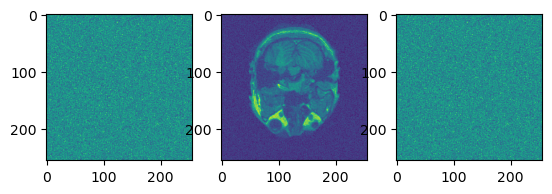

In [98]:
fig, axis = plt.subplots(1,3)
timestep = torch.tensor(-1)
axis[0].imshow(noise_scheduler.add_noise(img, noise, timestep).squeeze()/2+0.5)
timestep = torch.tensor(25)
axis[1].imshow(noise_scheduler.add_noise(img, noise, timestep).squeeze()/2+0.5)
timestep = torch.tensor(999)
axis[2].imshow(noise_scheduler.add_noise(img, noise, timestep).squeeze()/2+0.5)

In [92]:
config.num_inference_steps = 50 
config.intermediate_timestep = 1

In [93]:
noise_scheduler.set_timesteps(50)

In [94]:
timestep= config.num_inference_steps-config.intermediate_timestep

In [95]:
noise_scheduler.timesteps[timestep]

tensor(0)

In [96]:
noise_scheduler.timesteps[timestep:]

tensor([0])

In [97]:
noise_scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])